<a href="https://www.kaggle.com/code/jesusgraterol/bitcoin-keyzones-support-resistance-levels?scriptVersionId=137061760" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bitcoin KeyZones (Support & Resistance Levels)

Even though financial markets don't follow any easy-to-identify patterns, as the number of factors that influence the price are significantly large and not always present in historic data that can be accessed by individuals, support and resistance levels (KeyZones) are very helpful when it comes down to trading with trend-following and/or dollar cost averaging strategies.

KeyZones are price levels that act as barriers to price movement. Support levels are prices where buyers are likely to step in and buy, preventing the price from falling further. Resistance levels are prices where sellers are likely to step in and sell, preventing the price from rising further.

It is important to note that support and resistance levels are not always reliable. The price of an asset can break through a support or resistance level if there is a significant change in supply or demand.

This notebook will identify these levels (in a programmatic manner) by looking for areas where the price has repeatedly bounced off of a particular price level.

In [1]:
##################
## Dependencies ##
##################

from typing import TypedDict, Tuple, Union, Literal, List
from collections import Counter
from numpy import mean
from pandas import DataFrame, options, to_datetime
import utilities as utils
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
options.display.float_format = '{:.3f}'.format

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.9 MB/s eta 0:00:00


In [2]:
###########
## Types ##
###########


# Core KeyZone Types

# Reversal Kind
# A resistance reversal is a change in the price direction of an asset from uptrend to downtrend. 
# In the case of a support reversal, the direction goes from downtrend to uptrend.
IReversalKind = Literal["resistance", "support"]

# KeyZone Reversal
# Whenever a reversal is detected in the dataset, it is added to the KeyZone in which
# it took place.
class IReversal(TypedDict):
    id: int # The open time of the candlestick in which the reversal was initially detected.
    kind: IReversalKind

# KeyZone Record
class IKeyZone(TypedDict):
    id: int                    # The open time of the candlestick in which the reversal was initially detected.
    start: float               # Start Price (Highest High or Lowest Low)
    end: float                 # End Price (+/- zone_size% from start price)
    reversals: List[IReversal] # The list of reversals that took place within the zone

# KeyZone Build Dataset
class IMinifiedCandlestick(TypedDict):
    ot: int  # Open Time
    h: float # High
    l: float # Low


# Configuration
# The dictionary used to hold user input to prevent/limit the 
# editing of the source code.
class IConfig(TypedDict):
    ds_start: Union[int, str, None] = None
    ds_end: Union[int, str, None] = None
    candlesticks_interval: utils.IIntervalID
    zone_size: float
    zome_merge_distance_limit: float

In [3]:
#############
## Globals ##
#############

# Candlestick Chart Sizes
SMALL_FIG_SIZE: Tuple[int, int] = (6, 4)

# Configuration

In [4]:
CONFIG: IConfig = {
    # The date range that will be covered in the dataset
    "ds_start": "01/01/2023", # DD/MM/YYYY
    "ds_end": None, # All the way to the end of the candlesticks' history
    
    # The candlesticks interval that will be used in the dataset
    "candlesticks_interval": "1d",
    
    # The zone's size percentage. The start and end prices are based on this value.
    "zone_size": 3,
    
    # The minimum distance% zones should have. If the distance between 2 zones is
    # <= zone_merge_distance_limit% they will be merged.
    "zone_merge_distance_limit": 2
}

# Raw Dataset

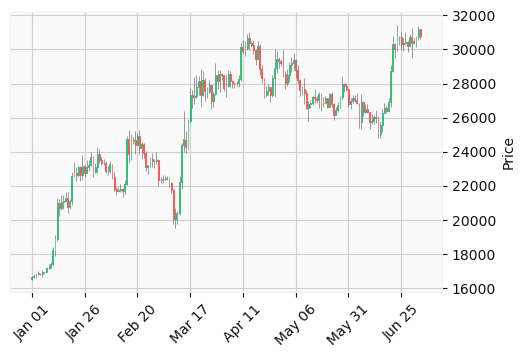

,ot,ct,o,h,l,c,v
count,185.000,185.000,185.000,185.000,185.000,185.000,185.000
mean,1680494400000.000,1680580799999.000,25504.415,26018.272,25065.520,25581.474,3903669656.127
std,4626637310.185,4626637310.185,3612.018,3634.385,3535.913,3571.451,3580280267.726
min,1672545600000.000,1672631999999.000,16533.040,16707.250,16499.010,16661.940,431403447.230
25%,1676520000000.000,1676606399999.000,23077.120,23452.000,22534.880,23079.270,1217494376.520
50%,1680494400000.000,1680580799999.000,26644.800,27045.450,26269.910,26752.000,2109809475.730
75%,1684468800000.000,1684555199999.000,28043.750,28530.000,27524.600,28128.420,6542348511.960
max,1688443200000.000,1688529599999.000,31195.680,31431.940,30620.000,31195.690,17607940168.530


In [5]:
# Download the dataset for the given interval
raw_ds: DataFrame = utils.get_historic_candlesticks(
    CONFIG["candlesticks_interval"], 
    start=CONFIG["ds_start"],
    end=CONFIG["ds_end"],
)
utils.plot_candlesticks(raw_ds, display_volume=False, figsize=SMALL_FIG_SIZE)
raw_ds.describe()

# KeyZones Calculator

In [6]:
class KeyZones:
    def __init__(self):
        """Initializes the instance, builds the KeyZones and prepares
        the state calculator.
        """
        # Init the zones
        self.zones: List[IKeyZone] = []

        # Init the zone size
        self.zone_size: float = CONFIG["zone_size"]

        # Init the distance in which zones should be merged
        self.zone_merge_distance_limit: float = CONFIG["zone_merge_distance_limit"]

        # Build the KeyZones
        self._build(raw_ds[["ot", "h", "l"]].to_records())
            
            
            
    def _build(self, lookback: List[IMinifiedCandlestick]) -> None:
        """Builds the key zones based on the processed candlesticks.
        
        Args:
            lookback: List[IMinifiedCandlestick]
                The dataset that will be used to build the KeyZones.
        """
        # Iterate over each candlestick scanning for reversals. The loop starts on the fourth 
        # item and ends on the fourth to last item as for a reversal to be detected it needs:
        # Resistance:  Higher than the previous 3 and next 3 candlesticks
        # Support:  Lower than the previous 3 and next 3 candlesticks
        for i in range(3, len(lookback) - 3, 1):
            # Check if a resistance reversal has occurred
            if lookback[i]["h"] > lookback[i - 3]["h"] and\
            lookback[i]["h"] > lookback[i - 2]["h"] and\
            lookback[i]["h"] > lookback[i - 1]["h"] and\
            lookback[i]["h"] > lookback[i + 1]["h"] and\
            lookback[i]["h"] > lookback[i + 2]["h"] and\
            lookback[i]["h"] > lookback[i + 3]["h"]:
                self._on_reversal(lookback[i], "resistance")

            # Check if a support reversal has occurred
            elif lookback[i]["l"] < lookback[i - 3]["l"] and\
            lookback[i]["l"] < lookback[i - 2]["l"] and\
            lookback[i]["l"] < lookback[i - 1]["l"] and\
            lookback[i]["l"] < lookback[i + 1]["l"] and\
            lookback[i]["l"] < lookback[i + 2]["l"] and\
            lookback[i]["l"] < lookback[i + 3]["l"]:
                self._on_reversal(lookback[i], "support")

        # Merge the nearby zones
        self._merge_nearby_zones()
            
            
            
            
            
    def _merge_nearby_zones(self) -> None:
        """Once all the zones have been calculated, the ones that are closer than
        zone_merge_distance_limit% are merged.
        """
        # Calculate the total number of detected zones
        zones_total: int = len(self.zones)

        # Init the final list of zones
        zones: List[IKeyZone] = []

        # Sort the calculated zones by price ascending (low to high)
        self.zones = sorted(self.zones, key=lambda d: d["start"])

        # Check if there zones that need to be merged
        merged: bool = False
        for i in range(zones_total):
          # Make sure it hasn't already been merged
          if not merged:
            # Check if there is a next item before proceeding
            if i < zones_total - 1:
              # Calculate the % change between the current end and the next start
              distance: float = utils.calculate_percentage_change(self.zones[i]["end"], self.zones[i + 1]["start"])

              # Check if the current and next zones should be merged
              if distance <= self.zone_merge_distance_limit:
                zones.append(self._merge_zones(self.zones[i], self.zones[i + 1]))
                merged = True

              # Otherwise, just add the zone
              else:
                zones.append(self.zones[i])

            # Checking last zone (unmerged), add it to the final list
            else:
                zones.append(self.zones[i])

          # The current item has already been merged with the previous one. Just skip it
          else:
            merged = False

        # Finally, update the instance zones
        self.zones = zones
            
            
            
    def _on_reversal(self, candlestick: IMinifiedCandlestick, reversal_kind: IReversalKind) -> None:
        """This function is invoked whenever a reversal is detected. It will check if the
        reversal occurred inside an existing zone. If so, it updates it. Otherwise,
        it adds the zone to the instance.

        Args:
          candlestick: IMinifiedCandlestick
            The candlestick in which the reversal was detected.
          reversal_kind: IReversalKind
            The type of reversal that took place.
        """
        # Firstly, calculate the price range
        start_price, end_price = self._calculate_price_range(candlestick, reversal_kind)

        # Check if the reversal took place in an existing zone
        zone_index: Union[int, None] = self._reversed_in_zone(start_price, end_price)

        # If an index was found, update the zone with the new data
        if isinstance(zone_index, int):
            self.zones[zone_index]["reversals"].append({ "id":  candlestick["ot"], "kind": reversal_kind })

        # The reversal took place in a new area, add it to the zones
        else:
            self.zones.append({
              "id": candlestick["ot"],
              "start": start_price,
              "end": end_price,
              "reversals": [ { "id":  candlestick["ot"], "kind": reversal_kind } ]
            })
            
            
            
    def _reversed_in_zone(self, start_price: float, end_price: float) -> Union[int, None]:
        """Based on a given price range, it will check if the reversal took
        place in an existing zone. If so, it will return the index in which it
        took place. Otherwise, it returns None.

        Args:
          start_price: float
          end_price: float
            The price range in which the reversal took place.

        Returns:
          Union[int, None]
        """
        # Iterate over each zone looking for a match
        for i in range(len(self.zones)):
            if (
                start_price >= self.zones[i]["start"] and \
                start_price <= self.zones[i]["end"]
            ) or \
             (
                end_price >= self.zones[i]["start"] and \
                end_price <= self.zones[i]["end"]
            ):
                return i

        # The reversal did not take place in an existing zone
        return None
            

    
    def _merge_zones(self, z1: IKeyZone, z2: IKeyZone) -> IKeyZone:
        """Converts 2 given zones into 1 by merging all its properties.

        Args:
          z1: IKeyZone
          z2: IKeyZone
            The KeyZones to be merged.

        Returns:
          IKeyZone
        """
        # Init the reversals
        reversals: List[IReversal] = z1["reversals"] + z2["reversals"]

        # Order them by date ascending
        reversals = sorted(reversals, key=lambda d: d["id"])

        # Return the unified zone
        return {
            "id": z1["id"] if z1["id"] < z2["id"] else z2["id"], # The earliest detection should be the id
            "start": round(mean([z1["start"], z2["start"]]), 0),
            "end": round(mean([z1["end"], z2["end"]]), 0),
            "reversals": reversals
        }
    
    
    
    def _calculate_price_range(
        self, 
        candlestick: IMinifiedCandlestick, 
        reversal_kind: IReversalKind
    ) -> Tuple[float, float]:
        """Calculates the price range of a keyzone based on the type of reversal. Keep in mind that 
        prices go from low (start) to high (end).

        Args:
          candlestick: ICandlestick
            The candlestick in which the reversal was detected.
          reversal_kind: str
            The kind of reversal that was detected.

        Returns:
          Tuple[float, float]
          (start_price, end_price)

        """
        if reversal_kind == "resistance": # Calculate a resistance's price range
            return utils.alter_number_by_percentage(candlestick["h"], -(self.zone_size), precision=0), candlestick["h"]
        else: # Calculate a support's price range
            return candlestick["l"], utils.alter_number_by_percentage(candlestick["l"], self.zone_size, precision=0)


# KeyZones Build

KeyZones: 7


14/04/2023: $30070.0 -> $31000.0 | Reversals: 3

22/03/2023: $28568.0 -> $29452.0 | Reversals: 9

27/03/2023: $26508.14 -> $27303.0 | Reversals: 9

16/02/2023: $24922.0 -> $25681.0 | Reversals: 5

21/01/2023: $23099.0 -> $23813.0 | Reversals: 6

13/02/2023: $21351.07 -> $21992.0 | Reversals: 2

18/01/2023: $19978.0 -> $20578.0 | Reversals: 2


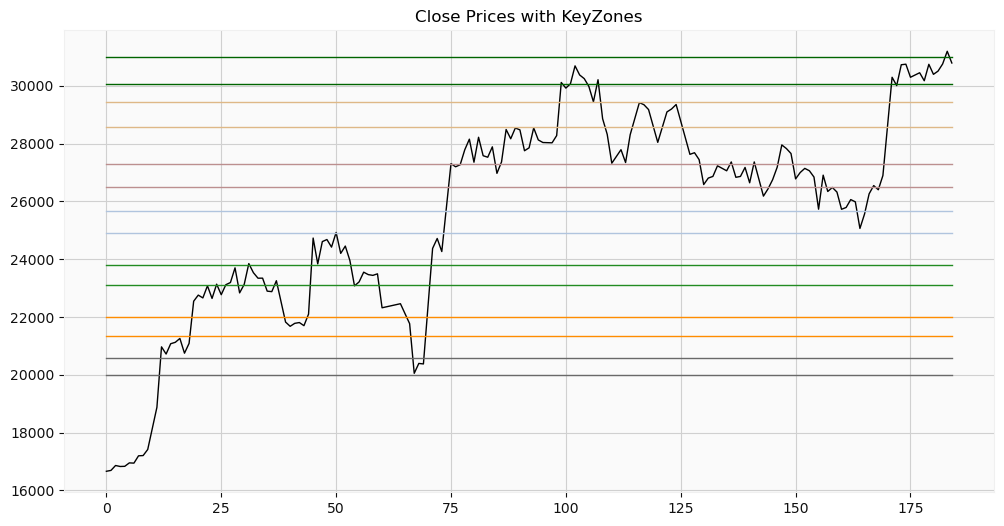

In [7]:
key_zones = KeyZones()
print(f"KeyZones: {len(key_zones.zones)}\n")
for zone in reversed(key_zones.zones):
    zone_str: str = f"\n{utils.from_milliseconds_to_date_string(zone['id']).split(',')[0]}: ${zone['start']} -> ${zone['end']}"
    zone_str += f" | Reversals: {len(zone['reversals'])}"
    print(zone_str)
colors: List[str] = [ 
    "dimgray", "darkorange", "forestgreen", "lightsteelblue", "rosybrown", "burlywood", "darkgreen", "cornflowerblue",  "lightcoral", "orange",
    "mediumseagreen", "midnightblue", "brown", "gold", "paleturquoise", "blue", "red", "darkkhaki",  "teal", "cyan",
    "salmon", "darkolivegreen", "slategray", "cadetblue", "magenta", "steelblue", "violet", "peru",  "hotpink", "crimson",
    "palegreen", "orangered", "darkorchid", "indigo", "lime", "tan", "goldenrod", "darkcyan",  "fuchsia", "deepskyblue",
]
fig = plt.figure(figsize=(12, 6))
plt.plot(raw_ds["c"].tolist(), linewidth=1, color="black")
for i, zone in enumerate(key_zones.zones):
    plt.plot([zone["start"]] * raw_ds.shape[0], linewidth=1, color=colors[i])
    plt.plot([zone["end"]] * raw_ds.shape[0], linewidth=1, color=colors[i])
plt.title("Close Prices with KeyZones")
plt.show()